In [32]:
# Copyright 2020 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Core training loop for neural QMC in JAX."""

import time
from absl import logging

from ferminet import curvature_tags_and_blocks

from ferminet import networks
from ferminet import pretrain
from ferminet.utils import system
import jax
from jax.experimental import multihost_utils
import jax.numpy as jnp
import kfac_jax

from ferminet_excited.main_utils import *
import numpy as np
import optax

# from ferminet.wavefunction import create_network

import time
import sys
import pandas as pd

from absl import logging
from ferminet.utils import system
from pyscf import gto
import os

from ferminet_excited import checkpoint
from ferminet_excited import constants
from ferminet_excited import hamiltonian
from ferminet_excited import loss as qmc_loss_functions
from ferminet_excited.loss import init_clipping_state
from ferminet_excited import mcmc
from ferminet_excited import base_config
from ferminet_excited.wavefunction import create_network
from ferminet_excited.configuration import Configuration

# 输出数据
train_schema = ['step', 'E_mean', 'E_mean_clip', 'E_var', 'E_var_clip', 'pmove', 'S','V', 'T', 'V_loc', 'V_nloc', 'delta_time']

# Optional, for also printing training progress to STDOUT.
# If running a script, you can also just use the --alsologtostderr flag.
logging.get_absl_handler().python_handler.stream = sys.stdout
logging.set_verbosity(logging.INFO)

# 读取配置文件
config_file = 'sample_config/config_minimal.yml'
raw_config, cfg = Configuration.load_configuration_file(config_file)

# 初始化设备
num_devices = jax.local_device_count()
num_hosts = jax.device_count() // num_devices
logging.info('Starting QMC with %i XLA devices per host '
              'across %i hosts.', num_devices, num_hosts)
if cfg.batch_size % (num_devices * num_hosts) != 0:
  raise ValueError('Batch size must be divisible by number of devices, '
                    f'got batch size {cfg.batch_size} for '
                    f'{num_devices * num_hosts} devices.')
host_batch_size = cfg.batch_size // num_hosts  # batch size per host
device_batch_size = host_batch_size // num_devices  # batch size per device
data_shape = (num_devices, device_batch_size)

# 苯
# mol = gto.Mole()
# mol.build(
#     atom=f'C 0.000000, 1.396792, 0.000000; C 0.000000, -1.396792, 0.000000; C 1.209657, 0.698396, 0.000000; C -1.209657, -0.698396, 0.000000; C -1.209657, 0.698396, 0.000000; C 1.209657, -0.698396, 0.000000; H 0.000000, 2.484212, 0.000000; H 2.151390, 1.242106, 0.000000;H -2.151390, -1.242106, 0.000000;H -2.151390, 1.242106, 0.000000;H 2.151390, -1.242106, 0.000000; H 0.000000, -2.484212, 0.000000',
#     basis={'C': 'ccecpccpvdz', 'H': 'ccecpccpvdz'},
#     ecp={'C': 'ccecp', 'H': 'ccecp'},
#     spin=0)

# 乙烯
postions_e = [[-0.675000, 0.000000, 0.000000],
    [0.675000, 0.000000, 0.000000],
    [-1.242900, 0.000000, -0.930370],
    [-1.242900, 0.000000, 0.930370],
    [1.242900, 0.000000, -0.930370],
    [1.242900, 0.000000, 0.930370]]

atom_coods = np.array([[-1.275565134081417, 0.0, 0.0], [1.275565134081417, 0.0, 0.0], 
[-2.348740600221915,0.0, -1.7581444945115967], [-2.348740600221915, 0.0, 1.7581444945115967], 
[2.348740600221915, 0.0, -1.7581444945115967], [2.348740600221915, 0.0, 1.7581444945115967]])

mol = gto.Mole()
mol.build(
    atom=[['C', postions_e[0]], ['C', postions_e[1]], ['H', postions_e[2]], ['H', postions_e[3]], ['H', postions_e[4]], ['H', postions_e[5]]],
    basis={'C': 'ccecpccpvdz', 'H': 'ccecpccpvdz'},
    ecp={'C': 'ccecp', 'H': 'ccecp'},
    spin=0)

cfg.system.pyscf_mol = mol
cfg.system.ecp_quadrature_id = 'icosahedron_12'
file_name = 'ecp'

# Check if mol is a pyscf molecule and convert to internal representation
if cfg.system.pyscf_mol:
# cfg.update(
#     system.pyscf_mol_to_internal_representation(cfg.system.pyscf_mol))
    cfg = pyscf_to_molecule(cfg)
    # cfg.system.electrons = (3, 1)
# elif cfg.system.molecule:
#     cfg = molecule_to_system(cfg)

cfg.log.save_path = "post_process/Li"+file_name
cfg.optim.n_epochs = 200
cfg.optim.num_psi_updates = 1

# Set training parameters
cfg.batch_size = 2048
cfg.pretrain.n_epochs = 0

writer_manager = None

# Convert mol config into array of atomic positions and charges
atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
charges = jnp.array([atom.charge for atom in cfg.system.molecule])
nspins = cfg.system.electrons
# Generate atomic configurations for each walker
batch_atoms = jnp.tile(atoms[None, ...], [device_batch_size, 1, 1])
batch_atoms = kfac_jax.utils.replicate_all_local_devices(batch_atoms)
batch_charges = jnp.tile(charges[None, ...], [device_batch_size, 1])
batch_charges = kfac_jax.utils.replicate_all_local_devices(batch_charges)

if cfg.debug.deterministic:
    seed = 23
else:
    seed = jnp.asarray([1e6 * time.time()])
    seed = int(multihost_utils.broadcast_one_to_all(seed)[0])
    key = jax.random.PRNGKey(seed)

init_params = ['data/expriment_2_1/C4H4/C2H4_10000/C2H4_0.0ecp/ferminet_2023_12_11_00:23:38/qmcjax_ckpt_010000.npz']

# Create parameters, network, and vmaped/pmaped derivations
Num_psi = 1
# 待求解波函数参数初始化文件
ckpt_restore_filenames = []
ckpt_save_paths = []
train_stats_file_names = []
for i in range(cfg.optim.num_psi_updates):
    # 新建待求解波函数地址
    ckpt_save_path = checkpoint.create_save_path(cfg.log.save_path)
    train_stats_file_name = os.path.join(ckpt_save_path, 'train_stats.csv')
    cfg.save(os.path.join(ckpt_save_path, "full_config.yml"))
    ckpt_restore_filenames.append(init_params[cfg.optim.num_psi_updates-1-i])
    ckpt_save_paths.append(ckpt_save_path)
    train_stats_file_names.append(train_stats_file_name)
    time.sleep(1)
# 已存在波函数参数文件
files = os.listdir(cfg.log.save_path)
files.sort()
for file in files:
    if 'ferminet_2023' in file:
        ckpt = os.listdir(os.path.join(cfg.log.save_path,file))
        ckpt.sort()
    if len(ckpt)>2:
        ckpt_restore_filenames.append(os.path.join(cfg.log.save_path, file, ckpt[-2]))
# ckpt_restore_filenames.sort()

# 初始化波函数及其参数
signed_networks = []
sign_networks = []
logabs_networks = []
orbital_networks = []
params = []
datas = []
mcmc_widths = []
pmoves = []
clipping_states = []
mcmc_steps = []
for ckpt_restore_filename in ckpt_restore_filenames:

    sign_network_vmap, batch_network, signed_network, param, data, clipping_state, mcmc_width, pmove, mcmc_step = init_wavefunction(
    cfg, atoms, charges, nspins, batch_atoms, batch_charges, key, host_batch_size, device_batch_size, data_shape, ckpt_restore_filename)

    sign_networks.append(sign_network_vmap)
    logabs_networks.append(batch_network)
    signed_networks.append(signed_network)
    datas.append(data)
    clipping_states.append(clipping_state)
    params.append(param)
    mcmc_widths.append(mcmc_width)
    pmoves.append(pmove)
    mcmc_steps.append(mcmc_step)

t_init = 0
opt_state_ckpt = None
sharded_key = kfac_jax.utils.make_different_rng_key_on_all_devices(key)

evaluate_loss = make_loss(logabs_networks, signed_networks, sign_networks, charges, nspins, cfg)

optimizer, opt_state, step = make_optimizer(cfg, evaluate_loss, params, sharded_key, datas, mcmc_steps, clipping_states, opt_state_ckpt=None)

sharded_key, datas, pmoves_t = init_mcmcs(cfg, evaluate_loss, params, mcmc_steps, datas, clipping_states, mcmc_widths, sharded_key)

INFO:absl:Starting QMC with 1 XLA devices per host across 1 hosts.


0
0
{'batch_size': 2048, 'debug': {'check_nan': False, 'deterministic': False}, 'log': {'features': False, 'local_energies': False, 'walkers': False, 'save_path': 'post_process/Liecp', 'restore_path': '', 'save_frequency': 1000, 'stats_frequency': 10}, 'mcmc': {'adapt_frequency': 100, 'blocks': 1, 'burn_in': 100, 'init_means': (), 'init_width': 0.8, 'move_width': 0.02, 'num_leapfrog_steps': 10, 'scale_by_nuclear_distance': False, 'steps': 10, 'use_hmc': False}, 'system': {'Z': [6, 6, 1, 1, 1, 1], 'R': [(-1.275565134081417, 0.0, 0.0), (1.275565134081417, 0.0, 0.0), (-2.348740600221915, 0.0, -1.7581444945115967), (-2.348740600221915, 0.0, 1.7581444945115967), (2.348740600221915, 0.0, -1.7581444945115967), (2.348740600221915, 0.0, 1.7581444945115967)], 'n_electrons': 12, 'n_up': 6, 'molecule': [], 'electrons': (6, 6), 'ndim': 3, 'units': 'bohr', 'pyscf_mol': None, 'set_molecule': None, 'make_local_energy_fn': '', 'make_local_energy_kwargs': {}, 'ecp': "{'C': 'ccecp', 'H': 'ccecp'}", 'type

INFO:absl:Loading checkpoint data/expriment_2_1/C4H4/C2H4_10000/C2H4_0.0ecp/ferminet_2023_12_11_00:23:38/qmcjax_ckpt_010000.npz


JastrowType.NONE
(6, 6) [(3, 1), (3, 1), (1, 0), (1, 0), (1, 0), (1, 0)]
[(3, 1), (3, 1), (0, 1), (0, 1), (0, 1), (0, 1)]


INFO:absl:==================================================
INFO:absl:Graph parameter registrations:
INFO:absl:[{'envelope': [{'pi': 'Auto[scale_and_shift_tag_1]',
                'sigma': 'Auto[scale_and_shift_tag_0]'},
               {'pi': 'Auto[scale_and_shift_tag_3]',
                'sigma': 'Auto[scale_and_shift_tag_2]'}],
  'layers': {'input': {},
             'streams': [{'double': {'b': 'Auto[repeated_dense_tag_1]',
                                     'w': 'Auto[repeated_dense_tag_1]'},
                          'single': {'b': 'Auto[repeated_dense_tag_0]',
                                     'w': 'Auto[repeated_dense_tag_0]'}},
                         {'double': {'b': 'Auto[repeated_dense_tag_3]',
                                     'w': 'Auto[repeated_dense_tag_3]'},
                          'single': {'b': 'Auto[repeated_dense_tag_2]',
                                     'w': 'Auto[repeated_dense_tag_2]'}},
                         {'double': {'b': 'Auto[repeated_de

In [8]:
import pandas as pd
import plotly.graph_objects as go

positions = pd.read_csv('post_process/bence.csv', header=None).to_numpy()

positions_up = positions[0:15]
positions_down = positions[21:36]

atom_coods = pd.read_csv('post_process/bence_atom.csv', header=None).to_numpy()
Z = atom_coods[:,1]
Z = [0 for i in range(21)]+[1 for i in range(21)]
# 绘制散点图
fig = go.Figure(data=[
    go.Scatter3d(
        x=[i[0] for i in positions[21:36]],
        y=[i[1] for i in positions[21:36]],
        z=[i[2] for i in positions[21:36]],
        mode='markers',
        marker=dict(
            size= 2,
            color= Z,                # set color to an array/list of desired values
            # colorscale='Viridis',   # choose a colorscale
            opacity=0.5
        )
    ),
    go.Scatter3d(
        x=[i[0] for i in positions[0:15]],
        y=[i[1] for i in positions[0:15]],
        z=[i[2] for i in positions[0:15]],
        mode='markers',
        marker=dict(
            size= 2,
            color= [3 for i in range(21)]+[4 for i in range(21)],                # set color to an array/list of desired values
            # colorscale='Viridis',   # choose a colorscale
            opacity=0.5
        )
    ),
    go.Scatter3d(
        x=[i[2] for i in atom_coods],
        y=[i[3] for i in atom_coods],
        z=[i[4] for i in atom_coods],
        mode='markers',
        marker=dict(
            size= [20 for i in range(6)] + [15 for i in range(6)],
            color= [15 for i in range(6)] + [12 for i in range(6)],                # set color to an array/list of desired values
            # colorscale='Viridis',   # choose a colorscale
            opacity=1
        )
    )
])
fig.show()
# fig.write_html("bence.html")

In [ ]:
from sympy import *
# 二元一次方程
x = Symbol('x')
y = Symbol('y')
solved_value=solve([(atom_coods[0,0]-x)**2+(atom_coods[0,2]-y)**2-1.3106944111768284, (atom_coods[2,0]-x)**2+(atom_coods[2,2]-y)**2-1.3106944111768284], [x, y])
print(solved_value)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9))
# plt.plot(atom_coods[:,0], atom_coods[:,1], 'o')

# i = 6

plt.plot(positions[:12,0], positions[:12,1], 'o')
# plt.plot(positions[21:,0], positions[21:,1], 'o')
for i in range(12):
    plt.text(positions[i,0], positions[i,1], str(i))
plt.xlim(-5,5)
plt.ylim(-5,5)

In [ ]:
# import numpy as np

# Ps = []
# Ss = []
# Rs = []
# theta = np.linspace(0, np.pi ,100)
# phi = np.linspace(0, 2*np.pi,100)
# Theta,Phi = np.meshgrid(theta,phi)
# for i in range(21):
#     R = 0.1
#     X = R*np.sin(Theta)*np.cos(Phi)-positions[i][0]
#     Y = R*np.sin(Theta)*np.sin(Phi)-positions[i][1]
#     Z = R*np.cos(Theta)-positions[i][2]
#     S = np.zeros_like(Z)
#     Ps.append([X,Y,Z,S])

# datas = [go.Surface(x=Ps[i][0],y=Ps[i][1],z=Ps[i][2],surfacecolor = Ps[i][3]) for i in range(21)]

# # 绘制散点图
# fig = go.Figure(data=datas)
# fig.show()

In [37]:
positions_ori = np.array([[0.425188, 0, 0.5],
[-0.425188, 0, -0.5],
[-2.23892832157152, 0, -0.618567522721434],
[-1.38537741273181, 0, 1.13957697179016],
[2.23892832157152, 0, 0.618567522721434],
[1.38537741273181, 0, -1.13957697179016],
[-0.425188, 0, 0.5],
[0.425188, 0, -0.5],
[-1.38537741273181, 0, -1.13957697179016],
[-2.23892832157152, 0, 0.618567522721434],
[1.38537741273181, 0, 1.13957697179016],
[2.23892832157152, 0, -0.618567522721434],])

x = jnp.linspace(-3, 3,100)
z = jnp.linspace(-2, 2,100)

X,Z = jnp.meshgrid(x,z)
Y = jnp.zeros_like(X)
position = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)],1)
device_batch_size = position.shape[0]
positions = np.tile(positions_ori.reshape(1,-1), [device_batch_size,1])
ei = 0
positions[:,ei*3:ei*3+3] = position
positions = positions[None]

In [38]:
atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
charges = jnp.array([atom.charge for atom in cfg.system.molecule])
nspins = cfg.system.electrons
# Generate atomic configurations for each walker
batch_atoms = jnp.tile(atoms[None, ...], [device_batch_size, 1, 1])
batch_atoms = kfac_jax.utils.replicate_all_local_devices(batch_atoms)
batch_charges = jnp.tile(charges[None, ...], [device_batch_size, 1])
batch_charges = kfac_jax.utils.replicate_all_local_devices(batch_charges)

spins = jnp.concatenate((jnp.ones(nspins[0]), -jnp.ones(nspins[1])))
spins = jnp.tile(spins[None], reps=(device_batch_size, 1))

# 电子坐标
datas[0].positions = kfac_jax.utils.broadcast_all_local_devices(positions)
# 电子自旋
datas[0].spins = kfac_jax.utils.broadcast_all_local_devices(spins[None])
# 原子坐标
datas[0].atoms = batch_atoms #kfac_jax.utils.broadcast_all_local_devices(batch_atoms)
# 核电荷
datas[0].charges = batch_charges #kfac_jax.utils.broadcast_all_local_devices(charges)
sharded_key, subkeys = kfac_jax.utils.p_split(sharded_key)
ptotal_energy = constants.pmap(evaluate_loss)
initial_energy, datas_temp = ptotal_energy(params,clipping_states, subkeys, datas)
clipping_states, psi_datas, aux_datas = datas_temp

spin_id = 0
det_id = 0
orb_id = 1
e_id = 0

S = psi_datas[0][0].reshape(100,100)



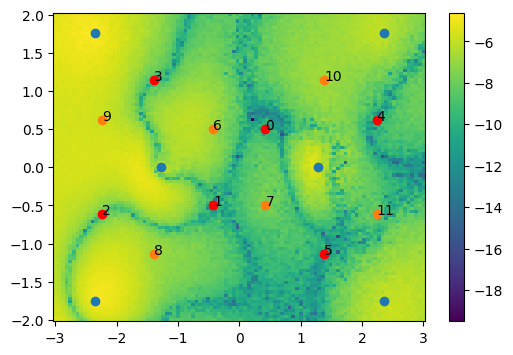

: 

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.pcolormesh(X,Z,jnp.log(jnp.abs(S)))
plt.plot(atom_coods[:,0], atom_coods[:,2], 'o')
plt.plot(positions_ori[0:6,0], positions_ori[0:6,2], 'ro')
plt.plot(positions_ori[6:,0], positions_ori[6:,2], 'o')
for i in range(12):
    plt.text(positions_ori[i,0], positions_ori[i,2], str(i))
plt.colorbar()

In [ ]:
spin_id = 0
det_id = 0
orb_id = 2
e_id = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))
# 循环画出Ss
for orb_id in range(12):
    S = aux_datas[0].orbital[0][0][spin_id][0,:,det_id, e_id, orb_id].reshape(100,100)
    plt.subplot(3,4,orb_id+1)
    plt.imshow(S)
    # plt.contourf(X,Z,S)
    # plt.contour(X,Z,S,[0,0.2])
    plt.colorbar()